In [1]:
pip install torch torchvision matplotlib

   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/204.1 MB 174.8 kB/s eta 0:19:25
   ---------------------------------------- 0.5/204.1 MB 174.8 kB/s 

In [1]:
import os

def clean_mac_junk_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.startswith("._"):
                os.remove(os.path.join(root, file))

clean_mac_junk_files('C:/Users/hp/Downloads/chest_xray')


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.ImageFolder(r"C:\Users\hp\Downloads\chest_xray", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze layers

# Replace final layer
model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(model.fc.in_features, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
for epoch in range(5):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()

    accuracy = 100 * correct / len(train_dataset)
    print(f"Epoch [{epoch+1}/5], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Validation
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()

val_accuracy = 100 * correct / len(val_dataset)
print(f"Validation Accuracy: {val_accuracy:.2f}%")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\hp\\Downloads\\chest_xray'

In [5]:
###my idea

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Example: load patient data
data = pd.read_csv("patients.csv")  # should include features + real severity score

X = data.drop(columns=["severity"])
y = data["severity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)


FileNotFoundError: [Errno 2] No such file or directory: 'patients.csv'

In [1]:
import numpy as np
from scipy.optimize import linprog

# Example severity scores predicted by model (higher = more severe)
severity_scores = np.array([0.95, 0.7, 0.5, 0.2, 0.85])  # Replace with your model's outputs
n_patients = len(severity_scores)
total_beds = 3  # Total beds available

# Coefficients for maximization (negate for linprog which minimizes by default)
c = -severity_scores

# Inequality constraint matrix and RHS (sum of beds ≤ total_beds)
A = np.ones((1, n_patients))
b = [total_beds]

# Bounds for x_i (binary relaxed to [0,1] for LP)
x_bounds = [(0, 1) for _ in range(n_patients)]

# Solve
res = linprog(c, A_ub=A, b_ub=b, bounds=x_bounds, method='highs')

# Allocate based on top scores if binary values needed
allocations = np.round(res.x)

print("Patient severity scores:", severity_scores)
print("Bed allocations (1=allocated):", allocations)


Patient severity scores: [0.95 0.7  0.5  0.2  0.85]
Bed allocations (1=allocated): [ 1.  1. -0.  0.  1.]


In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from scipy.optimize import linprog
import numpy as np
from sklearn.model_selection import train_test_split

# ----------------------------
# STEP 1: DEFINE LABELS + MAP
# ----------------------------
severity_map = {'mild': 1, 'moderate': 2, 'severe': 3, 'critical': 4}

# ----------------------------
# STEP 2: DEFINE DATASET CLASS
# ----------------------------
class ChestXrayDataset(Dataset):
    def __init__(self, image_dir, label_dict, transform=None):
        self.image_dir = image_dir
        self.label_dict = label_dict
        self.transform = transform
        self.files = list(label_dict.keys())

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.files[idx])
        image = Image.open(img_path).convert('RGB')
        label = severity_map[self.label_dict[self.files[idx]]] - 1  # 0-3 for CrossEntropyLoss
        if self.transform:
            image = self.transform(image)
        return image, label

# ----------------------------
# STEP 3: DATA TRANSFORMS
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ----------------------------
# STEP 4: LOAD YOUR LABELS
# ----------------------------
# Example label dictionary; replace with CSV loader if needed
label_dict = {
    'img1.jpg': 'moderate',
    'img2.jpg': 'severe',
    'img3.jpg': 'mild',
    'img4.jpg': 'critical',
    'img5.jpg': 'moderate',
    # Add all labels here...
}
image_dir = 'path_to_dataset_folder'  # Replace with your image folder

# Split train/test
keys = list(label_dict.keys())
train_keys, val_keys = train_test_split(keys, test_size=0.2, random_state=42)
train_labels = {k: label_dict[k] for k in train_keys}
val_labels = {k: label_dict[k] for k in val_keys}

train_set = ChestXrayDataset(image_dir, train_labels, transform)
val_set = ChestXrayDataset(image_dir, val_labels, transform)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

# ----------------------------
# STEP 5: MODEL SETUP
# ----------------------------
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ----------------------------
# STEP 6: TRAINING LOOP
# ----------------------------
for epoch in range(5):  # Few epochs for demo
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

# ----------------------------
# STEP 7: PREDICT NEW IMAGE
# ----------------------------
def predict_severity(model, image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
        severity_score = pred + 1  # Convert to 1–4
    return severity_score

# Upload your image and set path
test_image_path = 'path_to_test_image.jpg'
predicted_severity = predict_severity(model, test_image_path)
print(f"Predicted Severity Score: {predicted_severity}")

# ----------------------------
# STEP 8: LINEAR PROGRAMMING
# ----------------------------
# Severity scores for other patients already admitted or waiting
other_patients = [4, 3, 2, 2, 1]  # Simulated
all_scores = other_patients + [predicted_severity]
total_beds = 4

c = -np.array(all_scores)  # Maximize severity
A = [1] * len(all_scores)
b = [total_beds]
bounds = [(0, 1) for _ in all_scores]

res = linprog(c, A_ub=[A], b_ub=b, bounds=bounds, method='highs')
alloc = np.round(res.x)

print("Allocation vector:", alloc)
print("Is new patient allocated a bed?", bool(alloc[-1]))


C:\Users\Haripriya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Haripriya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Haripriya\\path_to_dataset_folder\\img1.jpg'

In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import os

# ----------------------------------------
# 1. SETUP
# ----------------------------------------
dataset_path = r'C:\Users\Haripriya\Desktop\Clg\Sem 2\OR\chest_xray\train'  # Replace with your actual path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------------------
# 2. TRANSFORMATIONS
# ----------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ----------------------------------------
# 3. LOAD DATASET USING ImageFolder
# ----------------------------------------
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes  # ['NORMAL', 'PNEUMONIA']
print("Classes:", class_names)

# Split into train and val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ----------------------------------------
# 4. LOAD DENSENET121
# ----------------------------------------
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)  # Binary classification
model = model.to(device)

# ----------------------------------------
# 5. TRAINING SETUP
# ----------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5

# ----------------------------------------
# 6. TRAINING LOOP
# ----------------------------------------
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Training Loss: {running_loss:.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# ----------------------------------------
# 7. SAVE MODEL
# ----------------------------------------
torch.save(model.state_dict(), 'densenet121_binary.pth')
print("Model saved as densenet121_binary.pth")


Classes: ['NORMAL', 'PNEUMONIA']


C:\Users\Haripriya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Haripriya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import os

# ----------------------------------------
# 1. SETUP
# ----------------------------------------
dataset_path = r'C:\Users\Haripriya\Desktop\Clg\Sem 2\OR\chest_xray\train'  # Replace with your actual path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------------------
# 2. TRANSFORMATIONS
# ----------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ----------------------------------------
# 3. LOAD DATASET USING ImageFolder
# ----------------------------------------
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes  # ['NORMAL', 'PNEUMONIA']
print("Classes:", class_names)

# Split into train and val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ----------------------------------------
# 4. LOAD DENSENET121
# ----------------------------------------
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)  # Binary classification
model = model.to(device)

# ----------------------------------------
# 5. TRAINING SETUP
# ----------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5

# ----------------------------------------
# 6. TRAINING LOOP
# ----------------------------------------
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Training Loss: {running_loss:.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# ----------------------------------------
# 7. SAVE MODEL
# ----------------------------------------
torch.save(model.state_dict(), 'densenet121_binary.pth')
print("Model saved as densenet121_binary.pth")


Classes: ['NORMAL', 'PNEUMONIA']


C:\Users\Haripriya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Haripriya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#-------------------------------------------

#TRAINING DenseNet121 MODEL

#-------------------------------------------

In [11]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import densenet121, DenseNet121_Weights
from torch.utils.data import DataLoader, random_split
import os

# ----------------------------------------
# 1. SETUP
# ----------------------------------------
dataset_path = r'C:\Users\Haripriya\Desktop\Clg\Sem 2\OR\chest_xray\train'  # Your dataset path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------------------
# 2. LOAD MODEL + WEIGHTS + TRANSFORMS
# ----------------------------------------
weights = DenseNet121_Weights.DEFAULT
model = densenet121(weights=weights)
model.classifier = nn.Linear(model.classifier.in_features, 2)  # Binary classification
model = model.to(device)

# Use recommended transforms
transform = weights.transforms()

# ----------------------------------------
# 3. LOAD DATASET USING ImageFolder
# ----------------------------------------
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes  # ['NORMAL', 'PNEUMONIA']
print("Classes:", class_names)

# Split into train and val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ----------------------------------------
# 4. TRAINING SETUP
# ----------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5

# ----------------------------------------
# 5. TRAINING LOOP
# ----------------------------------------
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Training Loss: {running_loss:.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# ----------------------------------------
# 6. SAVE MODEL
# ----------------------------------------
torch.save(model.state_dict(), 'densenet121_binary.pth')
print("Model saved as densenet121_binary.pth")


Classes: ['NORMAL', 'PNEUMONIA']
Epoch 1, Training Loss: 70.8464
Validation Accuracy: 96.46%
Epoch 2, Training Loss: 32.4017
Validation Accuracy: 96.65%
Epoch 3, Training Loss: 21.6359
Validation Accuracy: 97.32%
Epoch 4, Training Loss: 13.1224
Validation Accuracy: 97.80%
Epoch 5, Training Loss: 15.0226
Validation Accuracy: 97.03%
Model saved as densenet121_binary.pth


In [ ]:
#----------------------------------------------------------

#CREATING CONFUSION MATRIX AND CALCULATING THE METRICS

#----------------------------------------------------------

Classes: ['NORMAL', 'PNEUMONIA']


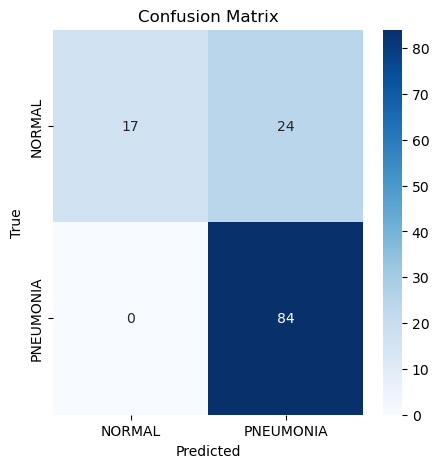

Accuracy : 80.80%
Precision: 77.78%
Recall   : 100.00%
F1 Score : 87.50%


In [21]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# ----------------------------------------
# 1. SETUP
# ----------------------------------------
dataset_path = r'C:\Users\Haripriya\Desktop\Clg\Sem 2\OR\chest_xray\test'  # Your dataset path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------------------
# 2. LOAD MODEL + WEIGHTS + TRANSFORMS
# ----------------------------------------
weights = DenseNet121_Weights.DEFAULT
model = densenet121(weights=weights)
model.classifier = nn.Linear(model.classifier.in_features, 2)  # Binary classification
model.load_state_dict(torch.load('densenet121_binary.pth', map_location=device))
model = model.to(device)
model.eval()

# Use recommended transforms
transform = weights.transforms()

# ----------------------------------------
# 3. LOAD DATASET USING ImageFolder
# ----------------------------------------
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes  # ['NORMAL', 'PNEUMONIA']
print("Classes:", class_names)

# Split into train and val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ----------------------------------------
# 4. CONFUSION MATRIX
# ----------------------------------------

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Loop over the validation set to get true labels and predicted labels
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

# Convert lists to numpy arrays for confusion matrix calculation
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Print metrics
print(f"Accuracy : {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall   : {recall * 100:.2f}%")
print(f"F1 Score : {f1 * 100:.2f}%")


In [ ]:
#--------------------------------------------------------

#PLOTTING GRAPHS FOR ACCURACY AND LOSS AGAINST EPOCHS

#--------------------------------------------------------

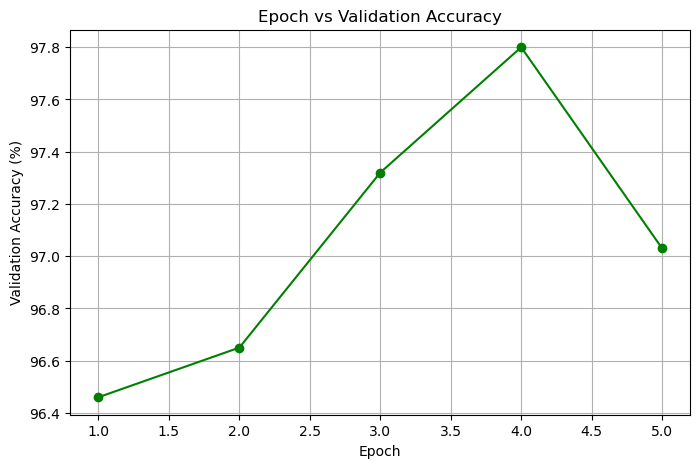

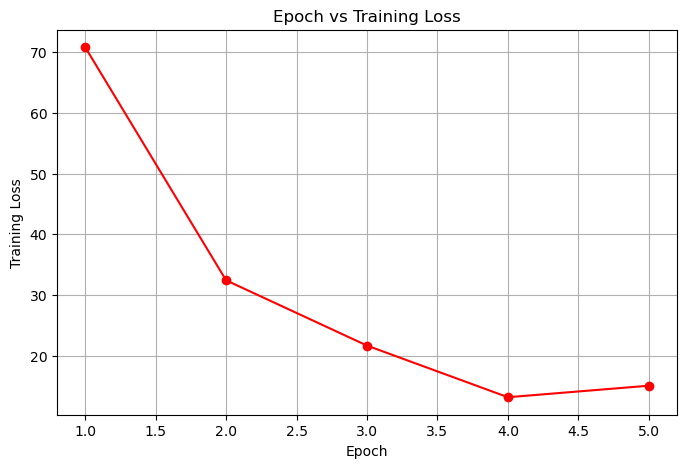

In [23]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4, 5]
training_loss = [70.8464, 32.4017, 21.6359, 13.1224, 15.0226]
validation_accuracy = [96.46, 96.65, 97.32, 97.80, 97.03]

# Plot Accuracy vs Epoch
plt.figure(figsize=(8, 5))
plt.plot(epochs, validation_accuracy, marker='o', color='green')
plt.title('Epoch vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True)
plt.savefig('accuracy_plot.png')  # Save as image
plt.show()

# Plot Loss vs Epoch
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, marker='o', color='red')
plt.title('Epoch vs Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid(True)
plt.savefig('loss_plot.png')  # Save as image
plt.show()


In [ ]:
#-----------------------------------------------------------------------------

#HOSPITAL BED ALLOCATION USING LPP(BINARY INTEGER LINEAR PROGRAMMING)

#-----------------------------------------------------------------------------

In [1]:
#### USING LPP
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights
from PIL import Image
import numpy as np
from scipy.optimize import linprog

# -------------------------------
# 1. Load Model
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = DenseNet121_Weights.DEFAULT
model = densenet121(weights=weights)
model.classifier = nn.Linear(model.classifier.in_features, 2)  # 2 classes: NORMAL / PNEUMONIA
model.load_state_dict(torch.load("densenet121_binary.pth", map_location=device))
model = model.to(device)
model.eval()

# -------------------------------
# 2. Define Transform
# -------------------------------
transform = weights.transforms()

# -------------------------------
# 3. Predict Severity from Image
# -------------------------------
def predict_severity(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
        # Map to simulated severity score (just for this demo)
        # NORMAL = 1, PNEUMONIA = 4
        severity = 1 if pred == 0 else 4
        print(f"Prediction: {'NORMAL' if pred == 0 else 'PNEUMONIA'}, Severity Score: {severity}")
        return severity

# -------------------------------
# 4. Hospital Bed Matrix
# -------------------------------
# 0 = empty, 1 = occupied
bed_matrix = np.array([
    [0, 1, 0],  # Patient 1 (can be assigned to Bed 1)
    [1, 0, 0],  # Patient 2 (can be assigned to Bed 0)
    [0, 0, 1],  # Patient 3 (can be assigned to Bed 2)
    [0, 1, 0],  # Patient 4 (no optimized solution for 4th patient since only 3 beds are available)
])

# -------------------------------
# 5. Allocate Bed Using Linear Programming
# -------------------------------
def allocate_bed_LPP(severity, bed_matrix):
    rows, cols = bed_matrix.shape

    # Number of patients = rows, number of beds = cols
    num_patients = rows
    num_beds = cols

    # Create the cost vector for Linear Programming (LPP)
    # We will prioritize high-severity patients (severity 4) with higher priority in the objective function
    c = []
    for i in range(num_patients):
        for j in range(num_beds):
            if severity == 4:
                c.append(-4)  # High priority (maximize this)
            else:
                c.append(-1)  # Lower priority (minimize this)
    
    # Constraints: Each bed can only be assigned to one patient
    A_ub = np.zeros((num_beds, num_patients * num_beds))
    b_ub = np.ones(num_beds)

    for j in range(num_beds):
        for i in range(num_patients):
            A_ub[j, i * num_beds + j] = 1

    # Each patient can only be assigned to one bed
    A_eq = np.zeros((num_patients, num_patients * num_beds))
    b_eq = np.ones(num_patients)

    for i in range(num_patients):
        for j in range(num_beds):
            A_eq[i, i * num_beds + j] = 1

    # Bounds for the decision variables (binary: 0 or 1)
    bounds = [(0, 1) for _ in range(num_patients * num_beds)]
    
    # Solve the Linear Programming problem using linprog
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        print(f"Optimal bed allocation found: {result.x}")
        # Convert the result into a bed allocation matrix
        allocation_matrix = np.reshape(result.x, (num_patients, num_beds))
        allocation_matrix = np.where(allocation_matrix < 1e-10, 0, allocation_matrix)
        print("Updated Bed Matrix with Allocation:")
        print(allocation_matrix)
        return allocation_matrix
    else:
        print("No optimal solution found. Please move to another hospital with vacancy.")
        return bed_matrix

# -------------------------------
# 6. Run Entire Flow
# -------------------------------
# Upload your image path here:
image_path = r'C:\Users\Haripriya\Desktop\Clg\Sem 2\OR\chest_xray\test\PNEUMONIA\person1_virus_7.jpeg'
severity = predict_severity(image_path)

# Allocate beds using Linear Programming (LPP)
allocated_beds = allocate_bed_LPP(severity, bed_matrix)

Prediction: PNEUMONIA, Severity Score: 4
No optimal solution found. Please move to another hospital with vacancy.


In [5]:
#####NEEDS IMPROVEMENT
#bed allocation:

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights
from PIL import Image
import numpy as np

# -------------------------------
# 1. Load Model
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = DenseNet121_Weights.DEFAULT
model = densenet121(weights=weights)
model.classifier = nn.Linear(model.classifier.in_features, 2)  # 2 classes: NORMAL / PNEUMONIA
model.load_state_dict(torch.load("densenet121_binary.pth", map_location=device))
model = model.to(device)
model.eval()

# -------------------------------
# 2. Define Transform
# -------------------------------
transform = weights.transforms()

# -------------------------------
# 3. Predict Severity from Image
# -------------------------------
def predict_severity(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
        # Map to simulated severity score (just for this demo)
        # NORMAL = 1, PNEUMONIA = 4
        severity = 1 if pred == 0 else 4
        print(f"Prediction: {'NORMAL' if pred == 0 else 'PNEUMONIA'}, Severity Score: {severity}")
        return severity

# -------------------------------
# 4. Hospital Bed Matrix
# -------------------------------
# 0 = empty, 1 = occupied
# You can change this matrix manually
bed_matrix = np.array([
    [1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])

# -------------------------------
# 5. Allocate Bed Based on Severity
# -------------------------------
def allocate_bed(severity, bed_matrix):
    rows, cols = bed_matrix.shape

    # Create utility matrix: e.g. prioritize first row for critical patients
    utility_matrix = np.zeros_like(bed_matrix, dtype=float)
    for i in range(rows):
        for j in range(cols):
            if bed_matrix[i, j] == 0:  # Only consider empty beds
                # Higher severity -> prioritize top-left (lower i + j)
                utility_matrix[i, j] = severity / ((i + j + 1)**2)  # Add 1 to avoid zero division

    # Find best bed
    best_index = np.unravel_index(np.argmax(utility_matrix), utility_matrix.shape)
    bed_matrix[best_index] = 1  # Allocate bed

    print(f"Bed allocated at: {best_index}")
    print("Updated Bed Matrix:")
    print(bed_matrix)
    return bed_matrix

# -------------------------------
# 6. Run Entire Flow
# -------------------------------
# Upload your image path here:
image_path = r'C:\Users\Haripriya\Desktop\Clg\Sem 2\OR\chest_xray\test\NORMAL\IM-0003-0001.jpeg'
severity = predict_severity(image_path)
bed_matrix = allocate_bed(severity, bed_matrix)


Prediction: PNEUMONIA, Severity Score: 4
Bed allocated at: (0, 1)
Updated Bed Matrix:
[[1 1 0 0]
 [0 0 0 0]
 [0 0 0 0]]


In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk
from PIL import ImageTk, Image
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights
import numpy as np
from scipy.optimize import linprog

# -------------------------------
# 1. Load Model
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = DenseNet121_Weights.DEFAULT
model = densenet121(weights=weights)
model.classifier = nn.Linear(model.classifier.in_features, 2)  # 2 classes: NORMAL / PNEUMONIA
model.load_state_dict(torch.load("densenet121_binary.pth", map_location=device))
model = model.to(device)
model.eval()

# -------------------------------
# 2. Define Transform
# -------------------------------
transform = weights.transforms()

# -------------------------------
# 3. Predict Severity from Image
# -------------------------------
def predict_severity(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
        severity = 1 if pred == 0 else 4
        return severity

# -------------------------------
# 4. Hospital Bed Matrix
# -------------------------------
bed_matrix = np.array([
    [0, 1, 0, 0],
    [1, 0, 1, 0],
    [0, 0, 0, 1],
])

# -------------------------------
# 5. Allocate Bed Using Linear Programming
# -------------------------------
def allocate_bed_LPP(severity, bed_matrix):
    rows, cols = bed_matrix.shape
    num_patients = rows
    num_beds = cols

    c = []
    for i in range(num_patients):
        for j in range(num_beds):
            if severity == 4:
                c.append(-4)  # High priority (maximize this)
            else:
                c.append(-1)  # Lower priority (minimize this)

    A_ub = np.zeros((num_beds, num_patients * num_beds))
    b_ub = np.ones(num_beds)

    for j in range(num_beds):
        for i in range(num_patients):
            A_ub[j, i * num_beds + j] = 1

    A_eq = np.zeros((num_patients, num_patients * num_beds))
    b_eq = np.ones(num_patients)

    for i in range(num_patients):
        for j in range(num_beds):
            A_eq[i, i * num_beds + j] = 1

    bounds = [(0, 1) for _ in range(num_patients * num_beds)]
    
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        allocation_matrix = np.reshape(result.x, (num_patients, num_beds))
        allocation_matrix = np.where(allocation_matrix < 1e-10, 0, allocation_matrix)
        return allocation_matrix
    else:
        return bed_matrix

# -------------------------------
# 6. GUI Functions
# -------------------------------
def upload_image():
    file_path = filedialog.askopenfilename(title="Select Image", filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])
    if file_path:
        image_path.set(file_path)
        img = Image.open(file_path).resize((150, 150))
        img = ImageTk.PhotoImage(img)
        image_label.config(image=img)
        image_label.image = img

def predict_and_allocate():
    image_path_value = image_path.get()
    if not image_path_value:
        messagebox.showerror("Error", "Please upload an image first!")
        return
    
    severity = predict_severity(image_path_value)
    allocation_matrix = allocate_bed_LPP(severity, bed_matrix)

    allocation_text = "\n".join([" ".join(map(str, row)) for row in allocation_matrix])
    result_text.config(state=tk.NORMAL)  # Enable the text widget
    result_text.delete(1.0, tk.END)  # Clear previous results
    result_text.insert(tk.END, f"Severity: {'PNEUMONIA' if severity == 4 else 'NORMAL'}\n")
    result_text.insert(tk.END, f"Bed Allocation Matrix:\n{allocation_text}")
    result_text.config(state=tk.DISABLED)  # Disable the text widget for editing

# -------------------------------
# 7. GUI Layout
# -------------------------------
root = tk.Tk()
root.title("Hospital Bed Allocation System")

# Set the window size
root.geometry("600x500")
root.config(bg="#f0f0f0")

# Variables
image_path = tk.StringVar()

# Frame for Upload Image and Buttons
frame = tk.Frame(root, bg="#f0f0f0")
frame.pack(pady=20)

# Upload Image Button
upload_button = ttk.Button(frame, text="Upload Image", command=upload_image, style="TButton")
upload_button.grid(row=0, column=0, padx=20, pady=10)

# Image Display Area
image_label = tk.Label(frame, width=150, height=150, relief="solid", bg="#dcdcdc")
image_label.grid(row=0, column=1, padx=20, pady=10)

# Predict Button
predict_button = ttk.Button(root, text="Predict Severity and Allocate Bed", command=predict_and_allocate, style="TButton")
predict_button.pack(pady=20)

# Result Display
result_text = tk.Text(root, width=60, height=10, wrap=tk.WORD, state=tk.DISABLED, font=("Arial", 12))
result_text.pack(pady=20)

# Style Customization
style = ttk.Style()
style.configure("TButton", padding=6, relief="flat", background="#4CAF50", font=("Arial", 12, "bold"))
style.map("TButton", background=[('active', '#45a049')])

root.mainloop()


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights
from PIL import Image
import numpy as np
from scipy.optimize import linprog
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk
import threading

# -------------------------------
# Load Model
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = DenseNet121_Weights.DEFAULT
model = densenet121(weights=weights)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model.load_state_dict(torch.load("densenet121_binary.pth", map_location=device))
model = model.to(device)
model.eval()
transform = weights.transforms()

bed_matrix = np.array([
    [0, 1, 0, 0],
    [1, 0, 1, 0],
    [0, 0, 0, 1],
])

def predict_severity(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
        severity = 1 if pred == 0 else 4
        return 'NORMAL' if pred == 0 else 'PNEUMONIA', severity

def allocate_bed_LPP(severity, bed_matrix):
    rows, cols = bed_matrix.shape
    num_patients = rows
    num_beds = cols

    c = [-severity for _ in range(num_patients * num_beds)]
    A_ub = np.zeros((num_beds, num_patients * num_beds))
    b_ub = np.ones(num_beds)
    for j in range(num_beds):
        for i in range(num_patients):
            A_ub[j, i * num_beds + j] = 1

    A_eq = np.zeros((num_patients, num_patients * num_beds))
    b_eq = np.ones(num_patients)
    for i in range(num_patients):
        for j in range(num_beds):
            A_eq[i, i * num_beds + j] = 1

    bounds = [(0, 1) for _ in range(num_patients * num_beds)]
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        allocation_matrix = np.reshape(result.x, (num_patients, num_beds))
        allocation_matrix = np.where(allocation_matrix < 1e-10, 0, allocation_matrix)
        return allocation_matrix
    else:
        return None

# -------------------------------
# GUI Implementation
# -------------------------------
def run_prediction(image_path, result_text):
    try:
        diagnosis, severity = predict_severity(image_path)
        result_text.insert(tk.END, f"Prediction: {diagnosis}\nSeverity Score: {severity}\n")

        allocated = allocate_bed_LPP(severity, bed_matrix)
        if allocated is not None:
            result_text.insert(tk.END, "\nOptimal Bed Allocation Matrix:\n")
            for row in allocated:
                result_text.insert(tk.END, f"{np.round(row).astype(int)}\n")
        else:
            result_text.insert(tk.END, "\nNo optimal bed allocation found.\n")
    except Exception as e:
        messagebox.showerror("Error", str(e))


def browse_file(entry_widget):
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg *.jpeg *.png")])
    entry_widget.delete(0, tk.END)
    entry_widget.insert(0, file_path)


def start_prediction(entry_widget, result_text):
    image_path = entry_widget.get()
    result_text.delete('1.0', tk.END)
    threading.Thread(target=run_prediction, args=(image_path, result_text)).start()


root = tk.Tk()
root.title("Pneumonia Detection and Bed Allocation")
root.geometry("600x500")
root.resizable(False, False)

style = ttk.Style()
style.configure("TButton", font=("Segoe UI", 10), padding=6)
style.configure("TLabel", font=("Segoe UI", 10))

frame = ttk.Frame(root, padding=20)
frame.pack(expand=True, fill=tk.BOTH)

entry_label = ttk.Label(frame, text="Select Chest X-ray Image:")
entry_label.pack(anchor=tk.W)

entry = ttk.Entry(frame, width=50)
entry.pack(side=tk.LEFT, padx=(0, 10))

browse_btn = ttk.Button(frame, text="Browse", command=lambda: browse_file(entry))
browse_btn.pack(side=tk.LEFT)

result_frame = ttk.Frame(root, padding=20)
result_frame.pack(fill=tk.BOTH, expand=True)

predict_btn = ttk.Button(root, text="Predict and Allocate Bed", command=lambda: start_prediction(entry, result_box))
predict_btn.pack(pady=10)

result_box = tk.Text(result_frame, wrap=tk.WORD, height=20, font=("Consolas", 10))
result_box.pack(fill=tk.BOTH, expand=True)

root.mainloop()